In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os


In [ ]:
import zipfile

# Specify the uploaded zip file name (use the correct filename if different)
zip_filename = 'EuroSAT_RGB.zip'

# Unzip the file to a specific directory
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/')  # Provide the path where you want to extract


In [ ]:
import os

# List the files in the directory
print(os.listdir('/content/'))


['.config', 'EuroSAT_RGB', 'EuroSAT_RGB.zip', 'sample_data']


In [ ]:
dataset_dir = '/content/EuroSAT_RGB'
files_and_folders = os.listdir(dataset_dir)
print(files_and_folders)

['HerbaceousVegetation', 'Highway', 'AnnualCrop', 'Residential', 'River', 'Pasture', 'PermanentCrop', 'Forest', 'Industrial', 'SeaLake']


In [ ]:
# Parameters
num_classes = 10  # EuroSAT has 10 classes
batch_size = 16
learning_rate = 0.001
num_epochs = 10

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load the EuroSAT dataset
train_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
#Split into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust the final layer
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 194MB/s]


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
import time

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        forward_start = time.time()
        outputs = model(images)
        forward_time = time.time() - forward_start

        loss = criterion(outputs, labels)

        # Backward pass and optimization
        backward_start = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time = time.time() - backward_start

        running_loss += loss.item()

        # Print the time taken for each pass
        print(f"Forward time: {forward_time:.4f}s, Backward time: {backward_time:.4f}s")

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Epoch time: {epoch_time:.2f}s")


Streaming output truncated to the last 5000 lines.
Forward time: 0.0189s, Backward time: 0.0175s
Forward time: 0.0164s, Backward time: 0.0178s
Forward time: 0.0168s, Backward time: 0.0174s
Forward time: 0.0167s, Backward time: 0.0180s
Forward time: 0.0169s, Backward time: 0.0182s
Forward time: 0.0169s, Backward time: 0.0183s
Forward time: 0.0190s, Backward time: 0.0187s
Forward time: 0.0186s, Backward time: 0.0188s
Forward time: 0.0165s, Backward time: 0.0182s
Forward time: 0.0170s, Backward time: 0.0180s
Forward time: 0.0172s, Backward time: 0.0182s
Forward time: 0.0171s, Backward time: 0.0187s
Forward time: 0.0173s, Backward time: 0.0248s
Forward time: 0.0169s, Backward time: 0.0185s
Forward time: 0.0177s, Backward time: 0.0184s
Forward time: 0.0179s, Backward time: 0.0177s
Forward time: 0.0180s, Backward time: 0.0181s
Forward time: 0.0173s, Backward time: 0.0200s
Forward time: 0.0194s, Backward time: 0.0294s
Forward time: 0.0171s, Backward time: 0.0191s
Forward time: 0.0165s, Backwa

In [ ]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model: {100 * correct / total:.2f}%')


Accuracy of the model: 97.30%


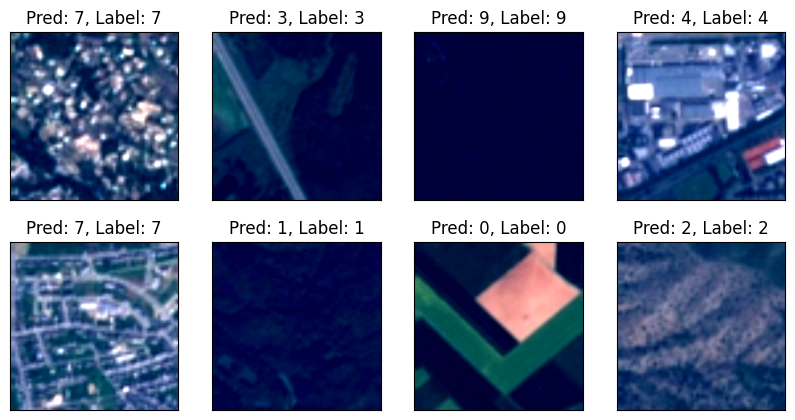

In [ ]:
# Plot sample predictions
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Move to CPU for matplotlib compatibility
images, predicted, labels = images.cpu(), predicted.cpu(), labels.cpu()

fig = plt.figure(figsize=(10, 5))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
    plt.imshow(images[idx].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.set_title(f"Pred: {predicted[idx]}, Label: {labels[idx]}")
plt.show()


Epoch 1/10, Train Loss: 0.1116, Val Loss: 0.1487
Epoch 2/10, Train Loss: 0.1092, Val Loss: 0.1667
Epoch 3/10, Train Loss: 0.0946, Val Loss: 0.0960
Epoch 4/10, Train Loss: 0.0910, Val Loss: 0.1708
Epoch 5/10, Train Loss: 0.0868, Val Loss: 0.1774
Epoch 6/10, Train Loss: 0.0946, Val Loss: 0.0966
Epoch 7/10, Train Loss: 0.0764, Val Loss: 0.1170
Epoch 8/10, Train Loss: 0.0808, Val Loss: 0.1102
Epoch 9/10, Train Loss: 0.0754, Val Loss: 0.1265
Epoch 10/10, Train Loss: 0.0710, Val Loss: 0.1165


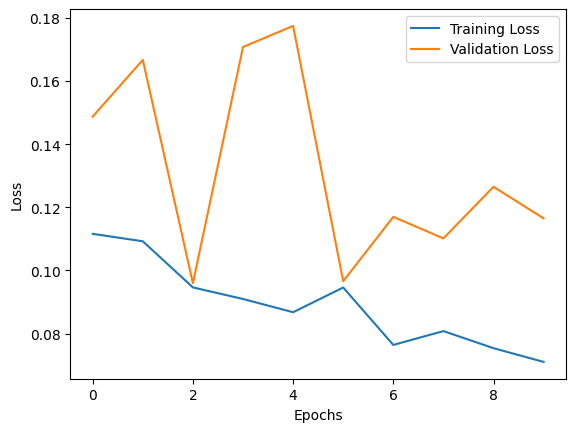

In [ ]:
#Monitoring Overfitting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Average training loss
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation loss
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
#Early Stopping
patience = 3  # Stop after 3 epochs of no improvement
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break


Epoch [1/10], Train Loss: 0.0683, Val Loss: 0.0974
Epoch [2/10], Train Loss: 0.0641, Val Loss: 0.0909
Epoch [3/10], Train Loss: 0.0620, Val Loss: 0.1096
Epoch [4/10], Train Loss: 0.0612, Val Loss: 0.1134
Epoch [5/10], Train Loss: 0.0629, Val Loss: 0.1081
Early stopping triggered


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have labels and predictions from your test set
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Confusion matrix and classification report
class_names = train_dataset.dataset.classes # Class names from the dataset
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification report (includes precision, recall, and F1-score per class)
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))


Confusion Matrix:
 [[550   0   1   2   0   1   7   0   1   0]
 [  0 579   3   0   0   0   0   0   1   0]
 [  1   2 559   1   0   5  26   1   0   0]
 [  0   0   0 485   2   0   1   0   1   0]
 [  0   0   2   6 497   0   8   2   0   0]
 [ 14   1   8   1   0 423   1   0   0   0]
 [ 12   0   3   0   0   1 489   0   1   0]
 [  0   0   0   3  10   0   6 607   0   0]
 [  7   0   1   8   0   1   0   0 451   0]
 [ 11   0   1   0   0   1   0   0   2 593]]
Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.92      0.98      0.95       562
              Forest       0.99      0.99      0.99       583
HerbaceousVegetation       0.97      0.94      0.95       595
             Highway       0.96      0.99      0.97       489
          Industrial       0.98      0.97      0.97       515
             Pasture       0.98      0.94      0.96       448
       PermanentCrop       0.91      0.97      0.94       506
         Residential       1.